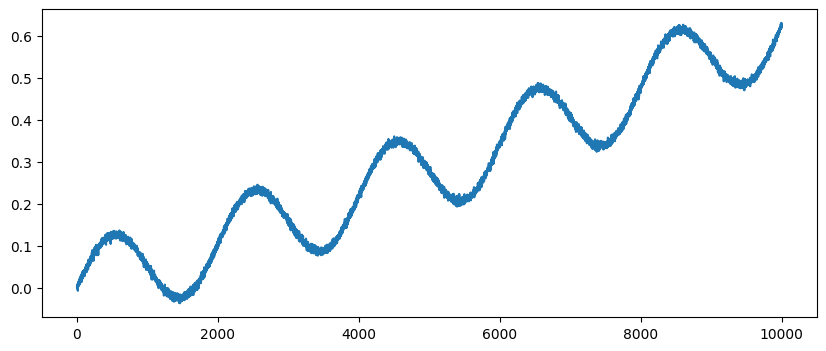

epoch   1 | train 1.030576 | val 0.157382
epoch   2 | train 0.013826 | val 0.015237
epoch   3 | train 0.003093 | val 0.001101
epoch   4 | train 0.001342 | val 0.001425
epoch   5 | train 0.000942 | val 0.000494
epoch   6 | train 0.000683 | val 0.000279


In [1]:
from dataset import *
from model import *
from train import *


def build_loaders(y, n, m, batch_size=128, stride=1, split=0.8):
    T = len(y)
    cut = int(T * split)
    train_ds = WindowDatasetV2(y, n=n, m=m, stride=stride, start=0, end=cut)
    val_ds = WindowDatasetV2(y, n=n, m=m, stride=stride, start=cut, end=T)

    train_loader = DataLoader(
        train_ds, batch_size=batch_size, shuffle=True, drop_last=True,
        collate_fn = collate_fixed
    )
    val_loader = DataLoader(
        val_ds, batch_size=batch_size, shuffle=False, drop_last=False,
        collate_fn=collate_fixed
    )
    return train_loader, val_loader


# 生成数据
T = 10_000
x = np.arange(T, dtype=np.float32)
y = generate_poly_series_V2(T=T, noise_std=0.005, seed=0)

plt.figure(figsize=(10, 4))
plt.plot(x, y[:, 1], label="y")
plt.show()

n, m = 64, 16
train_loader, val_loader = build_loaders(y, n, m, batch_size=256, stride=1, split=0.8)

# encoder input_size=2
# decoder input_size=3（因为有 bos_flag）
H = 128
num_heads = 8
num_layers = 2
dropout = 0.1

encoder = TransformerEncoder(
    input_size=2,
    key_size=H,
    query_size=H,
    value_size=H,
    num_hiddens=H,
    norm_shape=H,
    ffn_num_input=H,
    ffn_num_hiddens=4 * H,
    num_heads=num_heads,
    num_layers=num_layers,
    dropout=dropout,
)

decoder = TransformerDecoder(
    input_size=3,  # 关键：value+bos_flag
    output_size=1,
    key_size=H,
    query_size=H,
    value_size=H,
    num_hiddens=H,
    norm_shape=H,
    ffn_num_input=H,
    ffn_num_hiddens=4 * H,
    num_heads=num_heads,
    num_layers=num_layers,
    dropout=dropout,
)

net = EncoderDecoder(encoder, decoder)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_seq2seq_regression(
    net, train_loader, val_loader, num_epochs=6, lr=1e-3, device=device
)


In [2]:
import torch

def push_forward_step(dec_step: torch.Tensor, y_hat: torch.Tensor, dt: float) -> torch.Tensor:
    # dec_step: (B,1,3) [time, prev_y, bos]
    next_time = dec_step[:, :, 0:1] + dt
    next_bos  = torch.zeros_like(next_time)
    return torch.cat([next_time, y_hat, next_bos], dim=-1)  # (B,1,3)

@torch.no_grad()
def predict_autoregressive(net, X, m, dt, device=None, X_valid_len=None):
    net.eval()
    if device is None:
        device = next(net.parameters()).device
    X = X.to(device)
    dtype = X.dtype

    B = X.shape[0]
    if X_valid_len is None:
        X_valid_len = torch.full((B,), X.shape[1], dtype=torch.long, device=device)
    else:
        X_valid_len = X_valid_len.to(device)

    # 1) encoder
    enc_outputs = net.encoder(X, X_valid_len)
    state = net.decoder.init_state(enc_outputs, X_valid_len)

    # 2) 初始 token: [X[:, -1:], 1.0, 1.0]
    time_val0 = X[:, -1:, 0:2]  # (B,1,2)
    bos1 = torch.ones((B, 1, 1), device=device, dtype=dtype)
    dec_step = torch.cat([time_val0, bos1], dim=-1)   # (B,1,3)

    preds = []
    for _ in range(m):
        out, state = net.decoder(dec_step, state)  # out: (B,1, out_dim)
        print(out.shape)
        y_hat = out   # (B,1,1)
        preds.append(y_hat)

        dec_step = push_forward_step(dec_step=dec_step, y_hat=y_hat, dt=dt)  # (B,1,3)

    return torch.cat(preds, dim=1)  # (B,m,1)

In [3]:
@torch.no_grad()
def eval_autoregressive_mse(net, data_loader, device):
    net.eval()
    se_sum, count = 0.0, 0
    for X, X_len, Y, Y_len in data_loader:
        X, X_len, Y = X.to(device), X_len.to(device), Y.to(device)
        Y_hat = predict_autoregressive(net, X, m=Y.shape[1], dt=1 / (T - 1.0), device=device, X_valid_len=X_len)
        se_sum += ((Y_hat - Y) ** 2).sum().item()
        count += Y.numel()
    return se_sum / max(count, 1)

# 用法
mse = eval_autoregressive_mse(net, val_loader, device)
print("autoregressive MSE:", mse)


torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256,

In [4]:
@torch.no_grad()
def sliding_forecast_curves(net, series_np, n=64, m=64, horizons=(1,16,64),
                            batch_size=256, device=None):
    net.eval()
    if device is None:
        device = next(net.parameters()).device

    x = series_np.astype(np.float32)
    T_total = len(x)
    num_windows = T_total - n - m + 1
    if num_windows <= 0:
        raise ValueError("series too short for given n,m")
    for h in horizons:
        if not (1 <= h <= m):
            raise ValueError(f"horizon {h} 超出范围，要求 1<=h<=m={m}")

    # 全局绝对 time: (T_total,) in [0,1]
    t_abs = np.linspace(0.0, 1.0, T_total, dtype=np.float32)  # 或 np.arange(T_total)/(T_total-1)

    # 窗口 value: (W,n,1)
    X_val = np.stack([x[pos:pos+n] for pos in range(num_windows)], axis=0)  # (W,n)
    X_val = torch.from_numpy(X_val).unsqueeze(-1).to(device)                # (W,n,1)

    # 窗口 time: (W,n,1) —— 从全局 time 切窗
    X_time = np.stack([t_abs[pos:pos+n] for pos in range(num_windows)], axis=0)  # (W,n)
    X_time = torch.from_numpy(X_time).unsqueeze(-1).to(device)                   # (W,n,1)

    # 拼 X: (W,n,2) = [time_abs, value]
    X_all = torch.cat([X_time, X_val], dim=-1)  # (W,n,2)

    X_len = torch.full((num_windows,), n, dtype=torch.long, device=device)

    preds = {h: np.full(T_total, np.nan, dtype=np.float32) for h in horizons}

    dt = 1.0 / (T_total - 1.0)  # ✅ 全局 dt

    for s in range(0, num_windows, batch_size):
        e = min(s + batch_size, num_windows)
        Xb = X_all[s:e]
        Lb = X_len[s:e]

        # ✅ 把 dt 传给 predict_autoregressive（建议你改函数签名接收 dt）
        Yb = predict_autoregressive(net, Xb, m=m, device=device, X_valid_len=Lb, dt=dt)  # (B,m,1)
        Yb = Yb.squeeze(-1).cpu().numpy()

        for idx_in_batch, pos in enumerate(range(s, e)):
            base_t = pos + n
            for h in horizons:
                preds[h][base_t + (h - 1)] = Yb[idx_in_batch, h - 1]

    return preds


0.00010001000191550702
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 

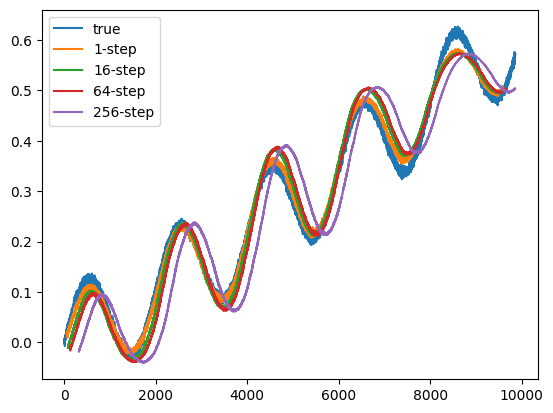

In [7]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# --- config ---
n = 64
m = 256
batch_size = 256
horizons = [1, 16, 64, 256]

L = 9855  # = 9728 + n + m - 1
test_x = y[0:0 + L].astype(np.float32)          # (L,2) where [:,0]=time, [:,1]=value
assert test_x.ndim == 2 and test_x.shape[1] == 2, test_x.shape

x2 = torch.from_numpy(test_x).to(device)       # (L,2)
dt = float(test_x[1, 0] - test_x[0, 0])         # 全局绝对时间步长（更稳健）
print(dt)
W = L - n - m + 1                               # 9728

# unfold on dim=0 (time axis)
# 对 2D: 输出是 (W, 2, n)，所以转置成 (W, n, 2)
Xw = x2.unfold(0, n, 1)[:W]                     # (W, 2, n)
Xw = Xw.transpose(1, 2).contiguous()            # (W, n, 2)

pred = {h: np.full(L, np.nan, dtype=np.float32) for h in horizons}

for s in range(0, W, batch_size):
    e = min(s + batch_size, W)
    Xb = Xw[s:e]                                 # (B, n, 2)

    Yb = predict_autoregressive(net, Xb, m=m, device=device, dt=dt)  # (B,m,1)
    Yb = Yb.squeeze(-1).detach().cpu().numpy()                       # (B,m)

    for h in horizons:
        k = h - 1
        idx = np.arange(s, e) + n + k
        pred[h][idx] = Yb[:, k]

true_val = test_x[:, 1]
t = np.arange(L)

plt.figure()
plt.plot(t, true_val, label="true")
plt.plot(t, pred[1],  label="1-step")
plt.plot(t, pred[16], label="16-step")
plt.plot(t, pred[64], label="64-step")
plt.plot(t, pred[256], label="256-step")
plt.legend()
plt.show()


torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size

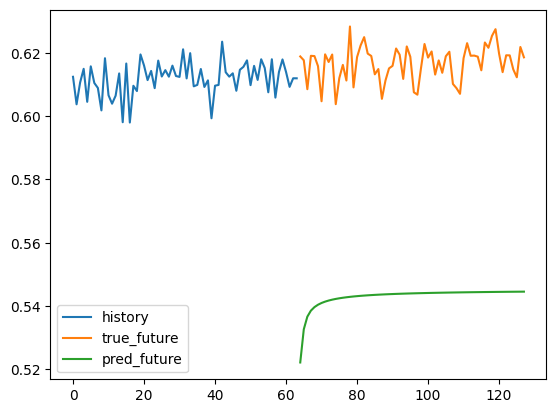

In [ ]:
# seg = y[8000:10000].astype(np.float32)
# n, m = 64, 64
# pos = 1800  # 注意：seg 内部下标，且 <= 1872

# x = torch.from_numpy(seg[pos:pos+n]).unsqueeze(0).unsqueeze(-1).to(device)
# y_true = seg[pos+n:pos+n+m]
# y_pred = predict_autoregressive(net, x, m=m, device=device).squeeze().detach().cpu().numpy()

# import matplotlib.pyplot as plt
# plt.figure()
# plt.plot(np.arange(n), seg[pos:pos+n], label="history")
# plt.plot(np.arange(n, n+m), y_true, label="true_future")
# plt.plot(np.arange(n, n+m), y_pred, label="pred_future")
# plt.legend(); plt.show()